# CIFAR-10 Recognition

In this notebook I' a going to try my best to solve famous [CIFAR-10 Object Recognition Task](https://www.kaggle.com/c/cifar-10). To solve this task I will be using [PyTorch 1.0](https://pytorch.org/).

In [12]:
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
from progressbar import progressbar as pb
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

Before uploading dataset, we need to transform it so that PyTorch will be able to work with dataset files. I'm going to turn files into torch.Tensor datatype and normalize all the files:

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

Now let's load train and test data:

In [3]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


CIFAR-10 consists of 60,000 32x32 color (RGB) images containing one of 10 object classes, with 6000 images per class. Here is the information about shapes of train and test datasets:

In [4]:
trainloader.dataset.train_data.shape

(50000, 32, 32, 3)

In [5]:
testloader.dataset.test_data.shape

(10000, 32, 32, 3)

Let's take a look at some examples from CIFAR-10 dataset:

In [37]:
inds = np.random.randint(0, 50000, 9)
images = trainloader.dataset.train_data[inds]
labels = np.array(trainloader.dataset.train_labels)[inds]
labels = np.array(classes)[labels]

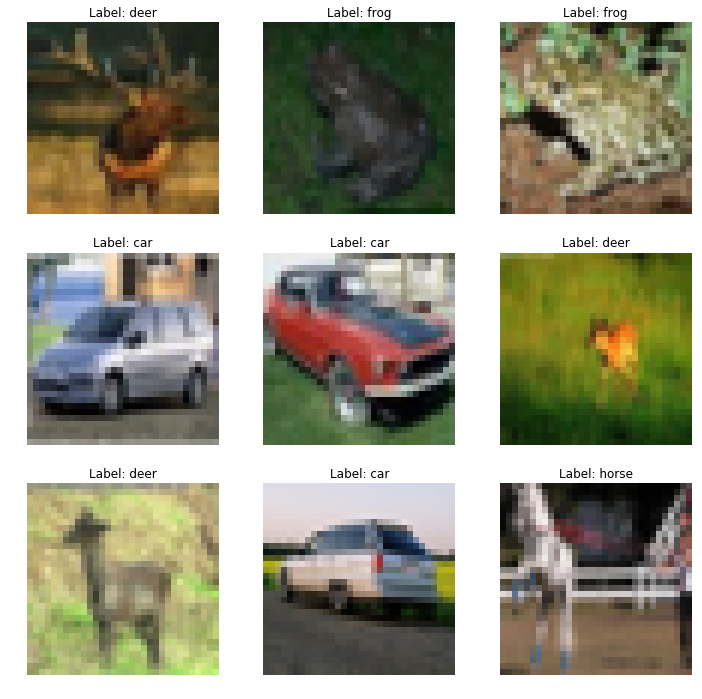

In [41]:
plt.figure(figsize=[12, 12])
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.title("Label: %s"%labels[i])
    plt.imshow(images[i],cmap='gray')
    plt.axis('off')
plt.show()

To classify images from CIFAR-10 I created a convolutional neural network with three convoluion layers and three dense layers. Here is the architecture of my neural net:

In [6]:
class MyConvNet(nn.Module):
    def __init__(self):
        super(MyConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, 1)
        self.conv2 = nn.Conv2d(64, 128, 3, 1)
        self.conv3 = nn.Conv2d(128, 256, 3, 1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(256 * 2 * 2, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 10)        
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 256 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))        
        x = self.fc3(x)
        
        return x

After each epoch I'm going to calculate loss function (Cross Entropy Loss) and mean accuracy. Let's define train and validation functions:

In [7]:
def train(model, train_loader, optimizer):
    train_loss, train_acc = [], []
    model.train()
    for i, batch in enumerate(pb(train_loader)):
        X_batch, y_batch = batch
        X_batch = X_batch.type(torch.cuda.FloatTensor)
        y_batch = y_batch.type(torch.cuda.LongTensor)

        optimizer.zero_grad()

        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        
        max_ind = y_pred.max(1, keepdim=True)[1]
        target_matches = torch.eq(max_ind, y_batch.data.view(len(y_batch), 1))
        accuracy = torch.sum(target_matches).cpu().numpy() / len(y_batch)
        
        train_loss.append(loss.item())
        train_acc.append(accuracy)
        
        loss.backward()
        optimizer.step()
        
    return np.mean(train_loss), np.mean(train_acc)

In [8]:
def validate(model, val_loader):
    model.eval()
    val_loss, val_acc = [], []
    for i, batch in enumerate(pb(val_loader)):
        X_batch, y_batch = batch
        X_batch = X_batch.type(torch.cuda.FloatTensor)
        y_batch = y_batch.type(torch.cuda.LongTensor)
        
        y_pred = model(X_batch)
        
        loss = loss_fn(y_pred, y_batch)
        
        max_ind = y_pred.max(1, keepdim=True)[1]
        target_matches = torch.eq(max_ind, y_batch.data.view(len(y_batch), 1))
        accuracy = torch.sum(target_matches).cpu().numpy() / len(y_batch)
        
        val_loss.append(loss.data.item())
        val_acc.append(accuracy)        

    
    return np.mean(val_loss), np.mean(val_acc)

During training I am going to use Adam optimizer with learning rate equal to 0.0001:

In [9]:
net = MyConvNet()
net.cuda()
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

Let's start training our neural net.

Epoch 10:
Train loss: 0.6361997868398876
Train accuracy: 0.7793518222506394
Validation loss: 0.838161270140083
Validation accuracy: 0.708797770700637


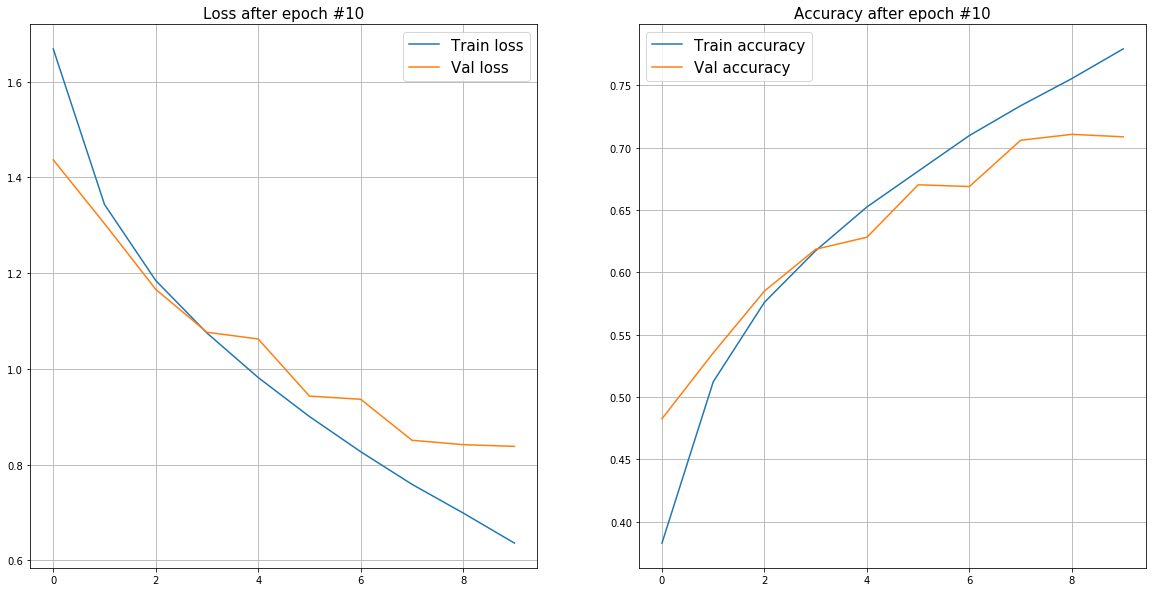

100% (10 of 10) |########################| Elapsed Time: 0:06:48 Time:  0:06:48


In [10]:
all_train_loss, all_train_acc = [], []
all_val_loss, all_val_acc = [], []

for epoch in pb(range(1,11)):
    cur_train = train(net, trainloader, optimizer)
    cur_val = validate(net, testloader)
    all_train_loss.append(cur_train[0])
    all_train_acc.append(cur_train[1])
    all_val_loss.append(cur_val[0])
    all_val_acc.append(cur_val[1])
    clear_output()
    print('Epoch {}:'.format(epoch))
    print("Train loss: {}".format(cur_train[0]))
    print("Train accuracy: {}".format(cur_train[1]))
    print("Validation loss: {}".format(cur_val[0]))
    print("Validation accuracy: {}".format(cur_val[1]))
    
    f, axarr = plt.subplots(1,2, figsize=(20,10))
    
    axarr[0].plot(all_train_loss, label='Train loss')
    axarr[0].plot(all_val_loss, label='Val loss')
    axarr[0].grid()
    axarr[0].legend(fontsize=15)
    axarr[0].set_title('Loss after epoch #{}'.format(epoch), size=15)

    axarr[1].plot(all_train_acc, label='Train accuracy')
    axarr[1].plot(all_val_acc, label='Val accuracy')
    axarr[1].grid()
    axarr[1].legend(fontsize=15)
    axarr[1].set_title('Accuracy after epoch #{}'.format(epoch), size=15)
    plt.show()

As we can see, my neural network achieved 70.8% accuracy on test data. Let's find out what is the accuracy for each class:

In [11]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.type(torch.cuda.FloatTensor)
        labels = labels.type(torch.cuda.LongTensor)
        y_pred = net(images)
        _, predicted = torch.max(y_pred, 1)
        c = (predicted == labels).squeeze()
    
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 75 %
Accuracy of   car : 80 %
Accuracy of  bird : 75 %
Accuracy of   cat : 52 %
Accuracy of  deer : 62 %
Accuracy of   dog : 61 %
Accuracy of  frog : 76 %
Accuracy of horse : 68 %
Accuracy of  ship : 76 %
Accuracy of truck : 79 %
